In [19]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import gzip
import json
from matplotlib import pyplot as plt

def load_jsonlines_to_df(file_path):
    """
    Loads a gzipped JSON Lines file into a Pandas DataFrame,
    processes the 'accession_type' to ensure it's a single string label,
    balances the dataset by sampling up to 10000 instances per class,
    and selects only the specified columns.

    :param file_path: Path to the .jsonl.gz file.
    :return: A balanced Pandas DataFrame with selected columns and a LabelEncoder.
    """
    with gzip.open(file_path, 'rt', encoding='utf-8') as gzfile:
        data = [json.loads(line) for line in gzfile]
    
    columns_to_keep = ['abstract', 'accession_type']
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df = df[columns_to_keep]
    
    # Ensure 'accession_type' exists
    if 'accession_type' not in df.columns:
        raise KeyError("Column 'accession_type' not found in the dataset.")
    
    # Process 'accession_type' to ensure it's a single string
    df['accession_type'] = df['accession_type'].apply(
        lambda labels: 'metagenomics' if 'metagenomics' in labels else 'other'
    )
    
    # Encode 'accession_type' into 'label'
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['accession_type'])
    
    # # Balance the dataset: sample up to 10000 instances per class
    # df_balanced = df.groupby('accession_type').apply(
    #     lambda x: x.sample(n=min(500, len(x)), random_state=0)
    # ).reset_index(drop=True)

    df_balanced = df.copy()
    # Diagnostic Checks
    print(f"Loaded DataFrame shape: {df_balanced.shape}")
    print("Label distribution after balancing:")
    print(df_balanced['accession_type'].value_counts())
    print("\nSample data:")
    print(df_balanced.head())
    
    df_balanced.rename(columns={'accession_type': 'class_label'}, inplace=True)
    return df_balanced, label_encoder

# File paths
file_path = '/home/stirunag/work/github/article_classifier/data/final_multi_label_trainingset.jsonl.gz'

data, label_encoder = load_jsonlines_to_df(file_path)
# Sample size
# n = 10000  # Set your desired sample size
# 
data
# 
# data

Loaded DataFrame shape: (219802, 3)
Label distribution after balancing:
accession_type
other           210302
metagenomics      9500
Name: count, dtype: int64

Sample data:
                                            abstract accession_type  label
0  Down-regulation of the Drosophila ribosomal pr...          other      1
1  Human chromosomal region 1q24 encodes two clon...          other      1
2  A bovine plasminogen activator was purified fr...          other      1
3  Staphylococcus aureus and Staphylococcus epide...          other      1
4  Kinetic analysis of two mutations within Pseud...          other      1


,abstract,class_label,label
0,Down-regulation of the Drosophila ribosomal pr...,other,1
1,Human chromosomal region 1q24 encodes two clon...,other,1
2,A bovine plasminogen activator was purified fr...,other,1
3,Staphylococcus aureus and Staphylococcus epide...,other,1
4,Kinetic analysis of two mutations within Pseud...,other,1
...,...,...,...
219797,Kaposi's sarcoma-associated herpesvirus (KSHV)...,other,1
219798,The pathway of autotrophic CO2 fixation was st...,other,1
219799,The mannose-sensitive hemagglutinin (MSHA) of ...,other,1
219800,Pseudomonas putida GJ31 contains an unusual ca...,other,1


In [20]:
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['cleaned_abstract'] = data['abstract'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stirunag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
import spacy
# Load spaCy model
nlp = spacy.load("en_core_sci_md")


In [22]:
# Generate spaCy embeddings
from tqdm import tqdm

def get_embedding(text, model):
    doc = model(text)
    return doc.vector  # Returns a 300-dimensional vector



# Enable tqdm for pandas
tqdm.pandas(desc="Generating Embeddings")
# Apply embeddings with progress tracking
data['embedding'] = data['cleaned_abstract'].progress_apply(lambda x: get_embedding(x, nlp))


Generating Embeddings: 100%|██████████| 219802/219802 [1:10:26<00:00, 52.01it/s]


In [23]:
data.to_csv('scispacy_embeddings.csv', index=False)

In [24]:
# Separate embeddings by class
import numpy as np
metagenomics_embeddings = np.vstack(data[data['class_label'] == 'metagenomics']['embedding'].values)
other_embeddings = np.vstack(data[data['class_label'] == 'other']['embedding'].values)

# Compute class-level mean embeddings
mean_metagenomics = np.mean(metagenomics_embeddings, axis=0)
mean_other = np.mean(other_embeddings, axis=0)


In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity scores
data['similarity_to_metagenomics'] = data['embedding'].apply(lambda x: cosine_similarity([x], [mean_metagenomics])[0][0])
data['similarity_to_other'] = data['embedding'].apply(lambda x: cosine_similarity([x], [mean_other])[0][0])

# Compute absolute difference as overlap score
data['overlap_score'] = np.abs(data['similarity_to_metagenomics'] - data['similarity_to_other'])


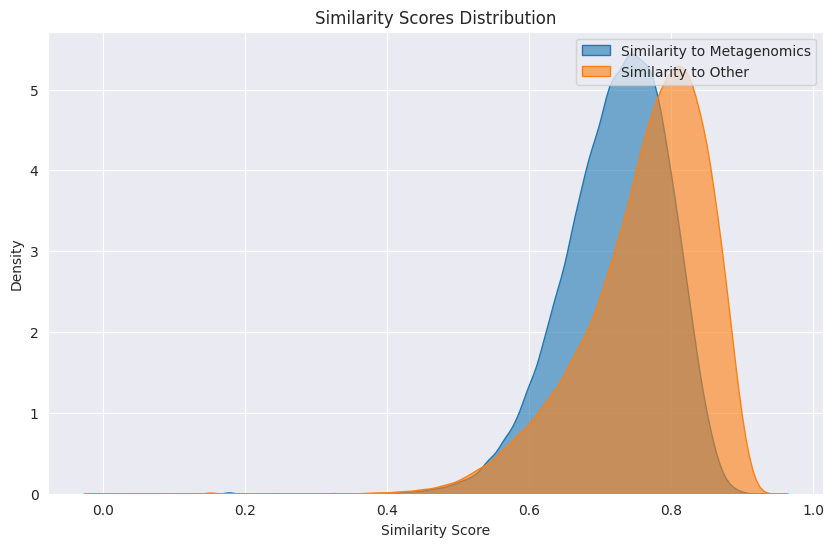

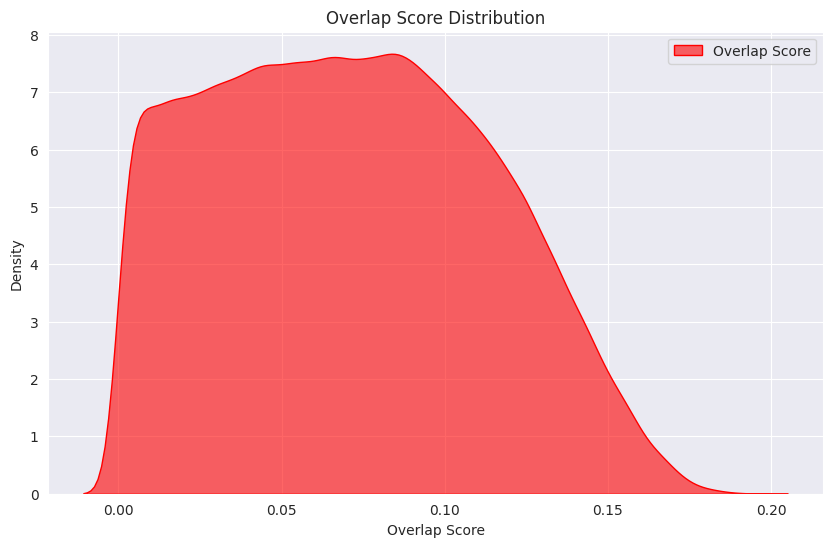

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot similarity_to_metagenomics
plt.figure(figsize=(10, 6))
sns.kdeplot(data['similarity_to_metagenomics'], label='Similarity to Metagenomics', fill=True, alpha=0.6)
sns.kdeplot(data['similarity_to_other'], label='Similarity to Other', fill=True, alpha=0.6)
plt.title('Similarity Scores Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot overlap_score
plt.figure(figsize=(10, 6))
sns.kdeplot(data['overlap_score'], label='Overlap Score', fill=True, alpha=0.6, color='red')
plt.title('Overlap Score Distribution')
plt.xlabel('Overlap Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [48]:
threshold = .10  # Example threshold for overlap
non_overlapping_data = data[data['overlap_score'] > threshold]
overlapping_data = data[data['overlap_score'] <= threshold]

print(f"Non-overlapping data size: {non_overlapping_data.shape[0]}")
print(f"Overlapping data size: {overlapping_data.shape[0]}")


Non-overlapping data size: 59339
Overlapping data size: 160463


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare non-overlapping data
X_non_overlap = np.vstack(non_overlapping_data['embedding'].values)
y_non_overlap = non_overlapping_data['class_label']

# Split data
y_encoded = label_encoder.fit_transform(y_non_overlap)
X_train, X_test, y_train, y_test = train_test_split(X_non_overlap, y_encoded, test_size=0.4, random_state=42)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.23      0.88      0.36       778
           1       1.00      0.90      0.94     22958

    accuracy                           0.90     23736
   macro avg       0.61      0.89      0.65     23736
weighted avg       0.97      0.90      0.93     23736



In [50]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': len(set(y_encoded)),
    'metric': 'multi_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lightgbm_clf = lgb.train(params, train_data, num_boost_round=100)
lightgbm_preds_proba = lightgbm_clf.predict(X_test)
lightgbm_preds = np.argmax(lightgbm_preds_proba, axis=1)
print(classification_report(y_test, lightgbm_preds))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 35603, number of used features: 200
[LightGBM] [Info] Start training from score -3.297833
[LightGBM] [Info] Start training from score -0.037664
              precision    recall  f1-score   support

           0       0.54      0.28      0.37       778
           1       0.98      0.99      0.98     22958

    accuracy                           0.97     23736
   macro avg       0.76      0.64      0.68     23736
weighted avg       0.96      0.97      0.96     23736



array([1, 1, 1, ..., 1, 1, 1])